**Visualization Variants for LLaVa models**

This notebook adapts `quickstart.ipynb` for LLaVa models, and showcases various visual saliency techniques.

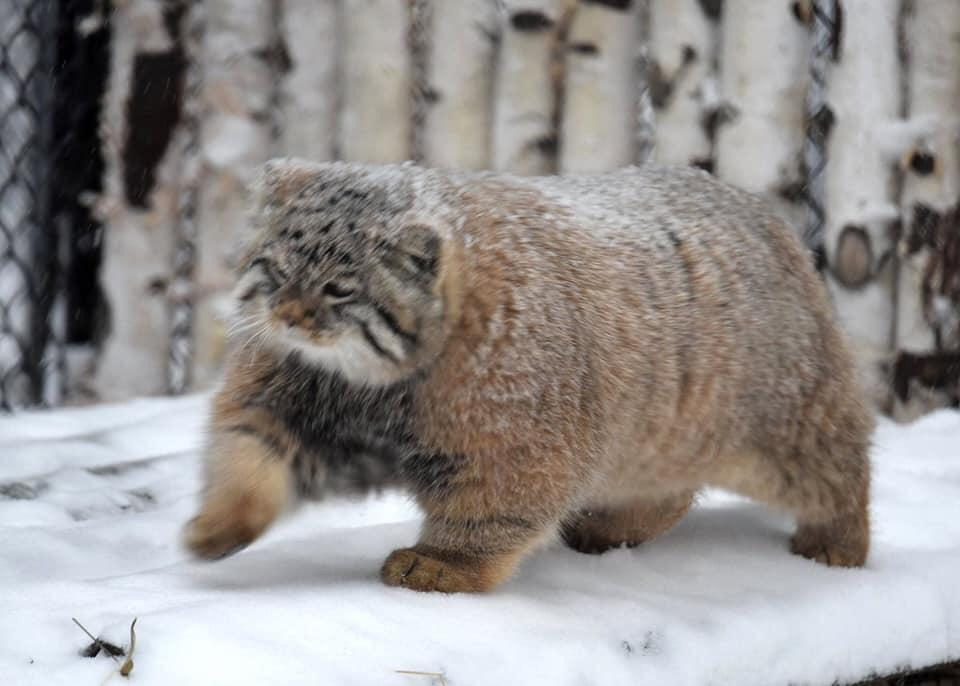

In [1]:
import requests
from PIL import Image

model_name = "llava-hf/llava-1.5-7b-hf"

prompt = "What is shown in this image?"
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"

image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image

## Initalization

Initialize the model and processor for the Qwen model you want to analyze. 

In [ ]:
import torch
import transformers
from transformers import AutoProcessor, LlavaForConditionalGeneration

transformers.utils.logging.set_verbosity_error()

device = "cuda" if torch.cuda.is_available() else "cpu"

model = LlavaForConditionalGeneration.from_pretrained(
    model_name,
    dtype=torch.float32,  # Requires float32 for loss computation
    attn_implementation="eager",  # to get attention weights
).to(device)

processor = AutoProcessor.from_pretrained(model_name, padding_side="left")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Process input images and text to prepare them for the model.

In [3]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": image_url},
            {"type": "text", "text": prompt},
        ],
    },
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    add_generation_prompt=True,
).to(device)

## Extract Saliency

Initalize the AGCAM saliency extractor with the correct model.


In [4]:
from vl_saliency import SaliencyTrace

trace = SaliencyTrace(model, processor)

Generate the response

In [ ]:
with torch.inference_mode():
    generated_ids = model.generate(**inputs, do_sample=True, max_new_tokens=200)

# Compute attention and gradients
trace.capture(**inputs, generated_ids=generated_ids, visualize_tokens=True)  # type: ignore

## Saliency Variants

Extract and visualize the saliency map.

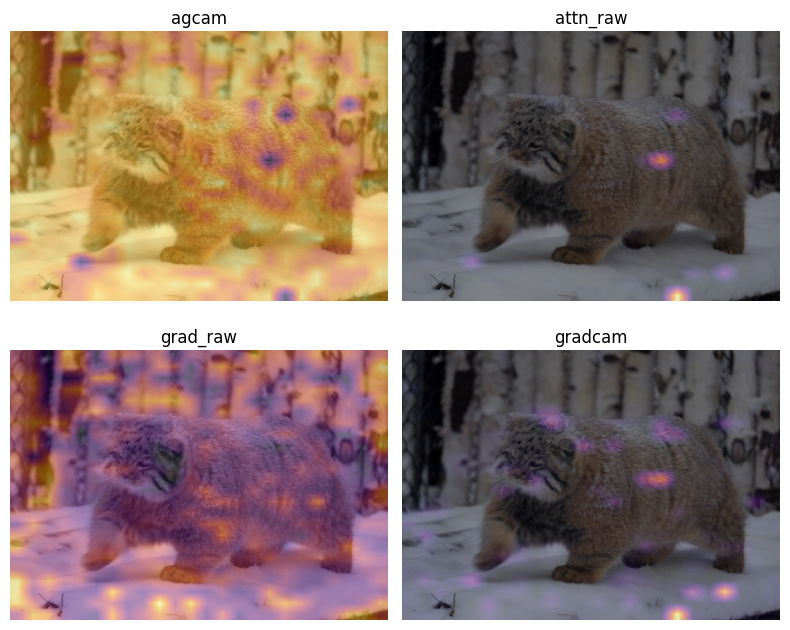

In [10]:
import math

import matplotlib.pyplot as plt
import numpy as np

from vl_saliency.methods.registry import list_methods
from vl_saliency.viz import overlay

methods = list_methods()

cols = 2
rows = math.ceil(len(methods) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = np.array(axes).ravel()

for ax, method in zip(axes, methods, strict=False):
    saliency_map = trace.map(token=615, method=method)  # Token for "animal"
    overlay(saliency_map, image, ax=ax, title=method, show_colorbar=False)

plt.tight_layout()
plt.show()

Compare different layers:

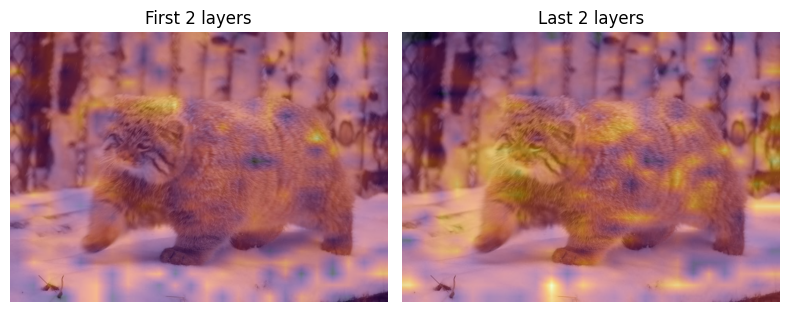

In [15]:
cols = 2
fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))
axes = np.array(axes).ravel()


saliency_map = trace.map(token=615, layers=2)  # First 2 layers
overlay(saliency_map, image, ax=axes[0], title="First 2 layers", show_colorbar=False)

saliency_map = trace.map(token=615, layers=-2)  # Last 2 layers
overlay(saliency_map, image, ax=axes[1], title="Last 2 layers", show_colorbar=False)

plt.tight_layout()
plt.show()

Or different aggregation methods

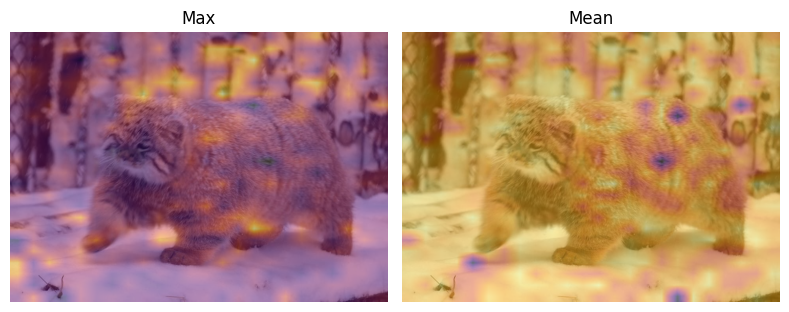

In [17]:
cols = 2
fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))
axes = np.array(axes).ravel()


saliency_map = trace.map(token=615, layer_reduce="max", head_reduce="max")
overlay(saliency_map, image, ax=axes[0], title="Max", show_colorbar=False)

saliency_map = trace.map(token=615, layer_reduce="mean", head_reduce="mean")
overlay(saliency_map, image, ax=axes[1], title="Mean", show_colorbar=False)

plt.tight_layout()
plt.show()